In [1]:
import sys
import subprocess
import os 

import glob
import multiprocessing

In [2]:
sys.path.append('../../')
from extract_glycan_info import parse_gf_result

Script: Find glycosidic dihedral, average B-factor, and ring shape of glycans from PDB
Author:Rajan Kandel <rajan.kandel@uga.edu>
      *Woods Group, CCRC UGA
  
Currently under development.......
Last Update: Oct 2024

Citations:
1. https://glycam.org/cb/
2. https://glycam.org/portal/gf_home/
 


In [3]:
phi_dihedral=['C2','C1','O2','C2']
psi_dihedral=['C1','O2','C2','C3']

di_sugar=['NDG', 'BMA']
patterns1= ['NDG(*_*_)]-BMA(*_*_)', 'NDG(*_*_)-BMA(*_*_)','NDG(*_*_)]-[*]-BMA(*_*_)', 'NDG(*_*_)-[*]-BMA(*_*_)']
patterns2= ['DGlcpNAca1-2DManpb', 'DGlcpNAca1-2]DManpb', 'DGlcpNAca1-2[*]DManpb']
patterns=(patterns1,patterns2)

gf_result ='../../data_gf_query/a1-2D_GF_results.csv'

chimerax_path= '/bin/chimerax'
bfmp_path = '/home/rajan/apps/BFMP/detect_shape'


instant1 = parse_gf_result(gf_result, phi_dihedral, psi_dihedral, di_sugar, patterns, chimerax_path, bfmp_path)
instant1.read_gf_file()
instant1.dnl_pdbs()
instant1.create_pdb_glycan_dict() 
instant1.glycan_count()
instant1.select_pdbs()

========== Reading_gf_results =====================================
pdbs: ['1A0T', '1A0T', '1A0T', '1A0T', '1A0T', '1A0T', '1A14', '1AA5', '1AA5', '1AF6', '1AF6', '1AF6', '1AFC', '1AFC', '1AFC', '1AFC', '1AFC', '1AFC', '1AFC', '1AFC', '1AGM', '1AGM', '1BHG', '1BHG', '1BJI', '1BRR', '1BRR', '1BXH', '1BXH', '1BZB', '1C0Q', '1C0Q', '1C0R', '1C0R', '1C3N', '1CAP', '1CB8', '1CF3', '1CKL', '1CKL', '1CKL', '1CLY', '1CLZ', '1CPO', '1DBG', '1DBO', '1DOG', '1DOG', '1DP5', '1DPJ', '1DSR', '1DZE', '1E05', '1EX2', '1F4Y', '1F6A', '1F8B', '1F8C', '1F8D', '1F8E', '1FE0', '1FE4', '1FEE', '1FI1', '1FQ6', '1FVM', '1FVM', '1FVM', '1FVM', '1FVM', '1FVM', '1G0V', '1GAC', '1GAC', '1GAH', '1GAH', '1GAI', '1GAI', '1GAL', '1GLM', '1GLM', '1GNX', '1GPE', '1GPE', '1GSL', '1GW0', '1GW0', '1GYA', '1GZ9', '1H3X', '1H3Y', '1H4P', '1H4P', '1HFU', '1HH3', '1HH3', '1HH3', '1HH3', '1HHA', '1HHA', '1HHA', '1HHA', '1HHC', '1HHC', '1HHC', '1HHC', '1HHF', '1HHF', '1HHF', '1HHF', '1HM2', '1HM2', '1HM3', '1HM3', '1HMU', '1HMU

In [4]:
%%capture output
instant1.generate_chimerax_script_to_compute_dihedral()

In [5]:
# Write the entire output to a file
with open('calc_dihedral2.cxc', 'w') as f:
    f.write(output.stdout)

In [6]:
# Use the custom split function
instant1.custom_split_chimerax_script('calc_dihedral2.cxc', 'calc_dihedral_part_')

chimerax script is run parallely in ./calc_dihedral_chimerax
Split into 1 files.


In [7]:
# Run the parallel execution and stitching
instant1.run_chimerax_script_parallel('./calc_dihedral_chimerax/calc_dihedral_part_*.cxc')

Executed 1 ChimeraX scripts in parallel.
Combined outputs into:  combined_chimerax_output.out


In [8]:
# instant1.run_chimerax_script('calc_dihedral2.cxc', 'calc_dihedral2.out')

In [9]:
# torsions = instant1.clean_up_chimerax_output('calc_dihedral2.out')
torsions = instant1.clean_up_chimerax_output('combined_chimerax_output.out')
torsions.to_csv('chimerax_output.csv', index=False)

number of pdb read: 5 
valid torsion1 and torsion2: (5, 5)


In [10]:
instant1.calc_BFactor()

In [11]:
instant1.find_bfmp_ring_shape()

(['5.F', '4.F'], ['4C1', '4C1'])
(['5.H', '4.H'], ['4C1', '-'])
(['5.d', '4.d'], ['-', 'OS2'])
(['3.e', '2.e'], ['OS2', 'O3B'])
(['3.c', '2.c'], ['-', '-'])


In [12]:
output_df = instant1.match_glycan_tree()

../../pdbs//1lcs.pdb F NDG 5 C1
../../pdbs//1lcs.pdb F BMA 4 O2
3339 3334
Connection found between 3339 and 3334
../../pdbs//6p3r.pdb H NDG 5 C1
../../pdbs//6p3r.pdb H BMA 4 O2
9810 9805
Connection found between 9810 and 9805
../../pdbs//6p3s.pdb d NDG 5 C1
../../pdbs//6p3s.pdb d BMA 4 O2
31845 31840
Connection found between(2) 31845 and 31840
../../pdbs//6p3s.pdb e NDG 3 C1
../../pdbs//6p3s.pdb e BMA 2 O2
31912 31907
Connection found between(2) 31912 and 31907
../../pdbs//6p3s.pdb c NDG 3 C1
../../pdbs//6p3s.pdb c BMA 2 O2
31750 31745
Connection found between(2) 31750 and 31745
droped rows: []


In [13]:
output_df.to_csv('DGlcpNAca1-2DManpb_ver2.1.csv',sep=',',index=False, columns=['pdb','glycam name','glycan','phi site','psi site','phi','psi','B factor(Avg)','BFMP ring shape'])
output_df.to_csv('DGlcpNAca1-2DManpb_ver3.csv',sep=',',index=False, columns=['pdb','phi site','psi site','phi','psi','B factor(Avg)','BFMP ring shape'])

In [14]:
################################
# print(instant1.pdbs)
# print(instant1.pdb_glycan_dict)

In [15]:
print(instant1.torsions)

        pdb                   phi site                   psi site       phi  \
0  1lcs.pdb  F NDG 5 C2 C1 BMA 4 O2 C2  F NDG 5 C1 BMA 4 O2 C2 C3  325.3944   
1  6p3r.pdb  H NDG 5 C2 C1 BMA 4 O2 C2  H NDG 5 C1 BMA 4 O2 C2 C3  214.0980   
2  6p3s.pdb  d NDG 5 C2 C1 BMA 4 O2 C2  d NDG 5 C1 BMA 4 O2 C2 C3  238.3440   
3  6p3s.pdb  e NDG 3 C2 C1 BMA 2 O2 C2  e NDG 3 C1 BMA 2 O2 C2 C3  235.0920   
4  6p3s.pdb  c NDG 3 C2 C1 BMA 2 O2 C2  c NDG 3 C1 BMA 2 O2 C2 C3   46.8957   

        psi                               B factor(Avg)  \
0  131.1560   ([NDG(5_F_), BMA(4_F_)], [105.24, 107.0])   
1  315.9314  ([NDG(5_H_), BMA(4_H_)], [136.17, 136.85])   
2   79.8608  ([NDG(5_d_), BMA(4_d_)], [124.31, 114.65])   
3   75.8586  ([NDG(3_e_), BMA(2_e_)], [132.48, 153.81])   
4   86.8852  ([NDG(3_c_), BMA(2_c_)], [129.37, 135.21])   

                                              glycan  \
0  NDG(5_F_)-BMA(4_F_)-MAN(3_F_)-NAG(2_F_)-NAG(1_...   
1  SIA(7_H_)-GAL(6_H_)-NDG(5_H_)-BMA(4_H_)-BMA(3_...   
2 

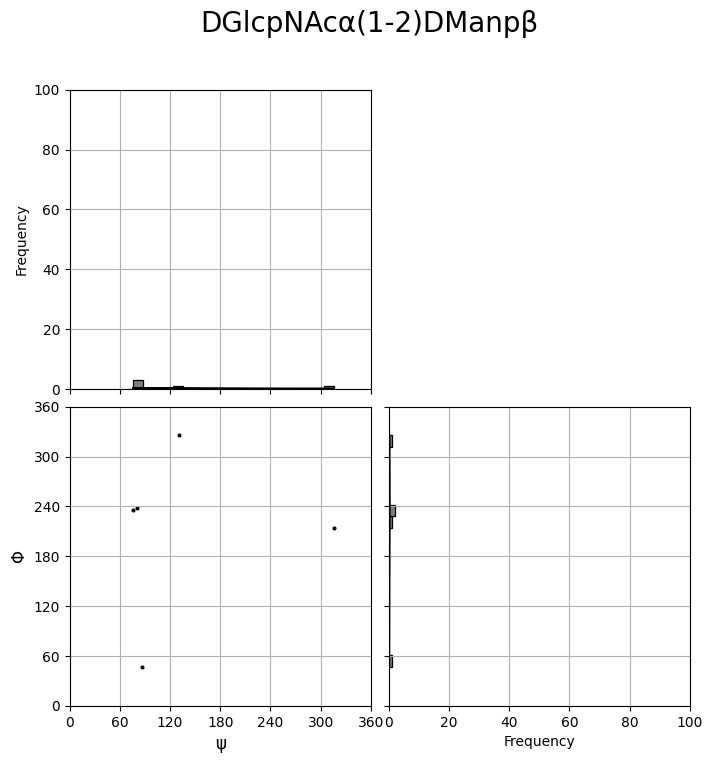

In [16]:
instant1.plot(torsions=instant1.torsions, title='DGlcpNAcα(1-2)DManpβ',max_histogram_scale=100,step_histogram_tick=20)